In [5]:
from __future__ import absolute_import, division, print_function

import tensorflow as tf_new
tf = tf_new.compat.v1
tf.logging.set_verbosity(tf.logging.ERROR)
import tensorflow_datasets as tfds

import math
import numpy as np
import matplotlib.pyplot as plt

# Улучшение отображения прогрессбара
import tqdm
import tqdm.auto
tqdm.tqdm = tqdm.auto.tqdm

In [6]:
dataset, metadata = tfds.load('fashion_mnist', as_supervised=True, with_info=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

In [7]:
class_names = ['Футболка / топ', "Шорты", "Свитер", "Платье",
              "Плащ", "Сандали", "Рубашка", "Кроссовок", "Сумка",
              "Ботинок"]

In [8]:
num_train_examples = metadata.splits['train'].num_examples
num_test_examples = metadata.splits['test'].num_examples
print('Количество тренировочных экземпляров: {}'.format(num_train_examples))
print('Количество тестовых экземпляров: {}'.format(num_test_examples))

Количество тренировочных экземпляров: 60000
Количество тестовых экземпляров: 10000


In [9]:
def normalize(image, label):
    image = tf.cast(image, tf.float32) # e.g. 100 to 100.0
    image /= 255
    return image, label

def mirror(images, labels):
    return tf.image.flip_up_down(images), labels

# метод ! map ! применяет функцию нормализации к каждому элементу в массиве
# тестовых и тренировочных наборах данных
train_dataset = train_dataset.map(normalize)
# test_dataset = test_dataset.map(normalize).map(mirror)
test_dataset = test_dataset.map(normalize)

In [10]:
# image, label = test_dataset.take(2)
# print(image)
# print(label)

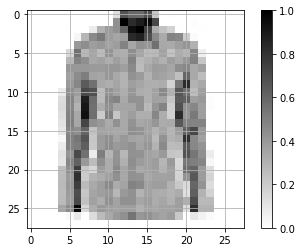

In [11]:
for image, label in test_dataset.take(1):
    break
image = image.numpy().reshape((28, 28))
plt.figure()
plt.imshow(image, cmap=plt.cm.binary) # Пиксель состоит из одной составляющей (оттенок серого), а не RGBA
plt.colorbar() # Шкала палитры: число-цвет
plt.grid() # Разметка, сетка, деления

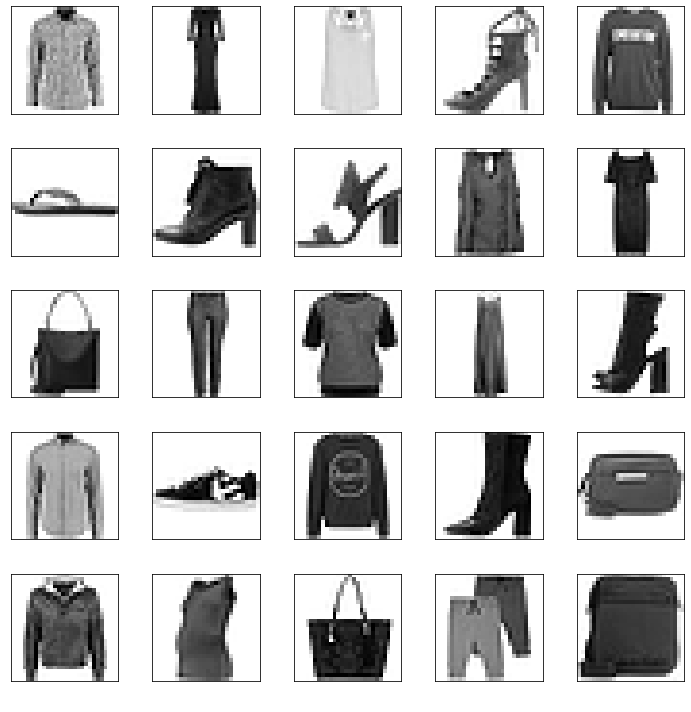

In [12]:
plt.figure(figsize=(10,10))
for i, (image, label) in enumerate(test_dataset.take(25)):
    image = image.numpy().reshape((28, 28))
    plt.subplot(5, 5, i+1)
    plt.imshow(image, cmap=plt.cm.binary)
    plt.xlabel(class_names[label], fontdict={'size':20, 'color':'white'})
    plt.xticks([])
    plt.yticks([])
plt.tight_layout() # Расположить так, чтобы не перекрывались

In [13]:
# Модель в colab с СНС (Сверточная нейроная сеть- сеть, имеющая сверточный слой)
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation=tf.nn.relu, input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D((2,2), strides=2),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2,2), strides=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])
"""
# Модель из видео
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28,28,1)),
#    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(units=256, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])"""

'\n# Модель из видео\nmodel = tf.keras.Sequential([\n    tf.keras.layers.Flatten(input_shape=(28,28,1)),\n#    tf.keras.layers.Dense(128, activation=tf.nn.relu),\n    tf.keras.layers.Dense(units=256, activation=tf.nn.relu),\n    tf.keras.layers.Dense(10, activation=tf.nn.softmax)\n])'

In [14]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [15]:
BATCH_SIZE = 32
train_dataset = train_dataset.repeat().shuffle(num_train_examples).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)


In [16]:
model.fit(train_dataset, epochs=5, steps_per_epoch=math.ceil(num_train_examples/BATCH_SIZE))

Epoch 1/5
1875/1875 [==============================] - 59s 32ms/step - loss: 0.3917 - accuracy: 0.8594

In [17]:
test_loss, test_accuracy = model.evaluate(test_dataset,steps=math.ceil(num_test_examples/BATCH_SIZE))
print("Точность на тестовом наборе данных: {}".format(test_accuracy))

313/313 [==============================] - 4s 11ms/step - loss: 0.2477 - accuracy: 0.9156

In [18]:
for test_images, test_labels in test_dataset.take(1):
    test_images = test_images.numpy()
    test_labels = test_labels.numpy()
    # Возвращает 10 вероятностей (принадлежность к каждой категории)
    predictions = model.predict(test_images)

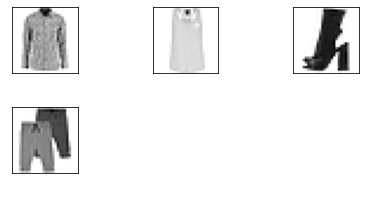

In [19]:
# Найти неправильные предсказания
wrong = list()
for i, pr in enumerate(predictions):
    if np.argmax(pr) != test_labels[i]:
        wrong.append(i)
# Shape plot
sh = int(np.sqrt(len(wrong))) + 1
for i, num in enumerate(wrong):
    plt.subplot(sh, sh, i+1)
    plt.imshow(test_images[num], cmap=plt.cm.binary)
    plt.xlabel(class_names[np.argmax(predictions[num])], fontdict={'size':20, 'color':'white'})
    # plt.xlabel(class_names[test_labels[num]], fontdict={'size':20, 'color':'white'})
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()

In [20]:
def plot_image(i, predictions_array, true_labels, images):
    predictions_array, true_label, img = predictions_array[i], true_labels[i], images[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img[..., 0], cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'
    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                         100 * np.max(predictions_array),
                                         class_names[true_label]),
               color=color)

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array[i], true_label[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array, color='#777777')
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

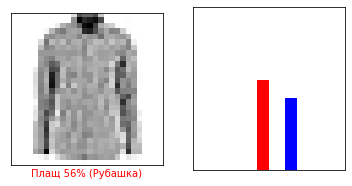

In [21]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1, 2, 2)
plot_value_array(i, predictions, test_labels)

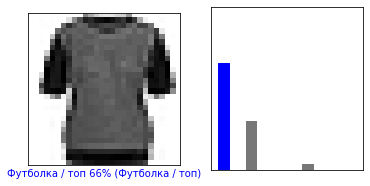

In [22]:
i=12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions, test_labels)

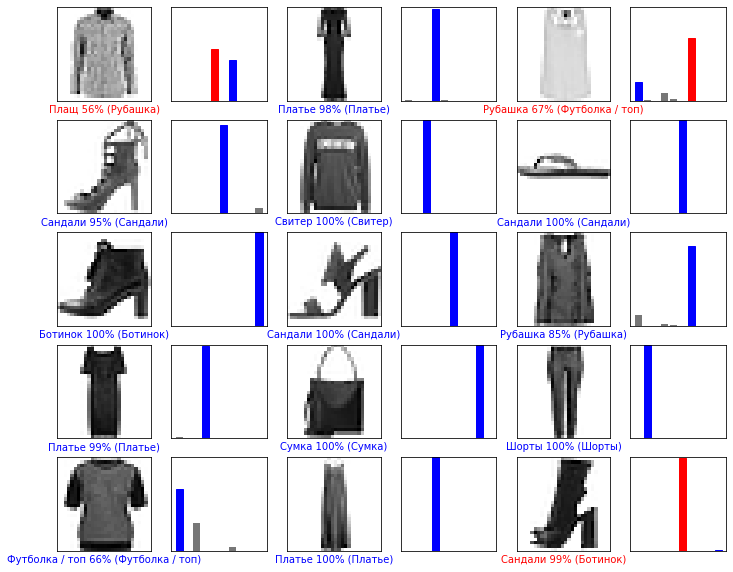

In [23]:
num_rows = 5
num_cols = 3
num_images = num_rows * num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i + 1)
    plot_image(i, predictions,test_labels, test_images)
    plt.subplot(num_rows, 2*num_cols, 2*i + 2)
    plot_value_array(i, predictions, test_labels)

In [39]:
# img = test_images[0]
# print(img.shape)
# img = np.array([img])
# print(img.shape)
img = test_images[:1, ...]

In [40]:
print(img.shape)
predictions_single = model.predict(img)
print(predictions_single)

(1, 28, 28, 1)
[[3.9687546e-04 6.0335935e-08 3.0906617e-03 3.7382315e-06 5.5550456e-01
  2.4918783e-08 4.4100371e-01 1.6450711e-09 3.2678136e-07 1.2619829e-07]]


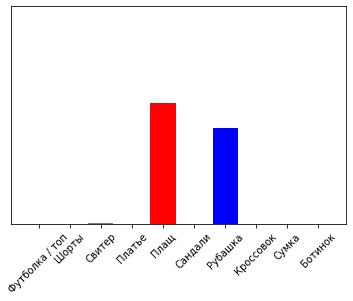

In [26]:
plot_value_array(0, predictions_single, test_labels)
_ = plt.xticks(range(10), class_names, rotation=45)

In [27]:
np.argmax(predictions_single[0])

4

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


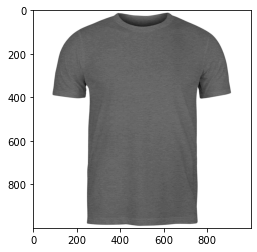

In [31]:
# Преобразовать новое цветное изображение в оттенки серого
from skimage import io
# поменять полюса черного и белого (1 - .. )
img = 1 - io.imread('./my clother/new/t shirt.jpg', as_gray=True)
plt.imshow(img, cmap=plt.cm.binary)

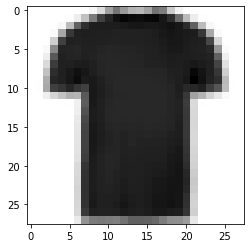

In [34]:
# Сжать изображение до нужного размера
from skimage.transform import resize
img = resize(img, (28, 28))
plt.imshow(img, cmap=plt.cm.binary)

In [42]:
# Предсказать, что это
img = [[img]]
answ = model.predict(img)
print(class_names[np.argmax(answ)])

Плащ
